# Part 2: Training an ML Model

This part of the MLRun getting-started tutorial walks you through the steps for training a machine-learning (ML) model, including data exploration and model testing.

The tutorial consists of the following steps:

1. [Setup and Configuration](#gs-tutorial-2-step-setup)
2. [Creating a training function](#gs-tutorial-2-step-create-a-training-function)
3. [Exploring the data with an MLRun marketplace function](#gs-tutorial-2-step-explore-data-w-mlrun-func)
4. [Testing your model](#gs-tutorial-2-step-test-model)

By the end of this tutorial you'll learn how to

- Create functions and track experiments while running them.
- Store artifacts to be used and managed in a central database.
- Leverage the MLRun functions marketplace.
- Run your code on a distributed Kubernetes cluster without any DevOps overhead

<a id="gs-tutorial-2-prerequisites"></a>

## Prerequisites

The following steps are a continuation of the previous part of this getting-started tutorial and rely on the generated outputs.
Therefore, make sure to first run [part 1](01-mlrun-basics.ipynb) of the tutorial.

<a id="gs-tutorial-2-step-setup"></a>

## Step 1: Setup and Configuration

<a id="gs-tutorial-2-mlrun-import-libraries"></a>

### Importing Libraries

In [1]:
from os import path
import mlrun

> 2021-01-24 19:10:32,992 [warning] Failed resolving version info. Ignoring and using defaults
> 2021-01-24 19:10:34,018 [warning] Unable to parse server or client version. Assuming compatible: {'server_version': '0.6.0-rc10', 'client_version': 'unstable'}


<a id="gs-tutorial-2-mlrun-envr-init"></a>

### Initializing Your MLRun Environment

Use the `set_environment` MLRun method to configure the working environment and default configuration. 
Define a project name and set the `project` parameter, setting the `user_project` flag will add the current user to the project name (avoiding a case of multiple users using the same project name).

In [2]:
# Set the project name
project_name_base = 'getting-started-tutorial'
# Initialize your MLRun environment and save the artifacts path
project_name, artifact_path = mlrun.set_environment(project=project_name_base, user_project=True)

<a id="gs-tutorial-2-nuclio-cfg"></a>

### Configuring Nuclio

The following code uses the `# nuclio: start-code` marker to instruct Nuclio to start processing code only from this location.

> **Note:** You can add code to define function dependencies and perform additional configuration after the `# nuclio: start-code` marker.

In [3]:
# nuclio: start-code

<a id="gs-tutorial-2-step-create-a-training-function"></a>

## Step 2: Creating a Training Function

An essential piece of artifact management and versioning is storing a model version. This allows the users to experiment with different models and compare their performance, without having to worry about losing their previous results.

The simplest way to store a model named `my_model` is with the following code:

``` python
from cloudpickle import dumps
model_data = dumps(model)
context.log_model(key='my_model', body=model_data, model_file='my_model.pkl')
```

You can also store any related metrics by providing a dictionary in the `metrics` parameter, such as `metrics={'accuracy': 0.9}`. Furthermore, any additional data that you would like to store along with the model can be specified in the `extra_data` parameter. For example `extra_data={'confusion': confusion.target_path}`

A convenient utility method, `eval_model_v2`, which calculates mode metrics is available in `mlrun.utils`.

See example below for a simple model trained using scikit-learn (normally, you would send the data as input to the function). The last 2 lines evaluate the model and log the model.

In [4]:
from sklearn import linear_model
from sklearn import datasets
from sklearn.model_selection import train_test_split
from cloudpickle import dumps
import pandas as pd

from mlrun.execution import MLClientCtx
from mlrun.datastore import DataItem
from mlrun.mlutils.data import get_sample
from mlrun.mlutils.plots import eval_model_v2

In [5]:
def train_iris(context: MLClientCtx,
               dataset: DataItem,
               label_column: str = "labels"):

    raw, labels, header = get_sample(dataset, sample=-1, label=label_column)
    
    # Basic scikit-learn iris SVM model
    X_train, X_test, y_train, y_test = train_test_split(
        raw, labels, test_size=0.2, random_state=42)
    
    context.log_dataset('train_set', 
                        df=pd.concat([X_train, y_train.to_frame()], axis=1),
                        format='csv', index=False, 
                        artifact_path=context.artifact_subpath('data'))

    context.log_dataset('test_set', 
                        df=pd.concat([X_test, y_test.to_frame()], axis=1),
                        format='csv', index=False, 
                        labels={"data-type": "held-out"},
                        artifact_path=context.artifact_subpath('data'))
    
    model = linear_model.LogisticRegression(max_iter=10000)
    model.fit(X_train, y_train)
    
    # Evaluate model results and get the evaluation metrics
    eval_metrics = eval_model_v2(context, X_test, y_test, model)
    
    # Log model
    context.log_model("model",
                      body=dumps(model),
                      artifact_path=context.artifact_subpath("models"),
                      extra_data=eval_metrics, 
                      model_file="model.pkl",
                      metrics=context.results,
                      labels={"class": "sklearn.linear_model.LogisticRegression"})

The following cell uses the `# nuclio: end-code` marker to mark the end of a Nuclio code section and instruct Nuclio to stop parsing the notebook at this point.<br>
> **Important:** Do not remove the end-code cell.

In [6]:
# nuclio: end-code

### Converting the Code to an MLRun Function

Use the MLRun `code_to_function` method to convert your notebook code into a project MLRun function &mdash; a function object with embedded code, which can run on the cluster.

The following code converts the code of your local `train_iris` function into `fn`, an MLRun function and registers it to the project. We specify the image `mlrun/ml-models` as the container image name to use to run the job. `mlrun/ml-models` includes  a wide variety of machine learning python packages (such as scikit-learn, TensorFlow and PyTorch), saving you the time to create your own image.

In [7]:
train_iris_func = mlrun.code_to_function(name='train_iris',
                                         handler='train_iris',
                                         kind='job',
                                         image='mlrun/ml-models')

### Mounting a Persistent Volume

When running jobs in Kubernetes, if we would like the job to read or write data, we need to give it access to a **Persistent Volume (PV)**.  This connects your function to the platform's shared file system and allows you to pass data from the platform to the function and get back the results (plots) directly into your notebook. A **Persistent Volume Claim (PVC)** is a request to access a PV, in MLRun we do that by calling `.apply` and providing it as input the mount function. `mount_v3io()` creates PVC to Iguazio's V3IO volume whereas `mount_pvc()` is a generic mount function to other storage types (such as NFS)

We'll use `auto_mount()` to choose the mount method that is applicable to your envionment. Calling `auto_mount()` without any parameters will access Iguazio's V3IO volume when `V3IO_ACCESS_KEY` and `V3IO_USERNAME` environment variables are set. Otherwise, it will attempt to access Kubernetes PVC volume when `MLRUN_PVC_MOUNT=<pvc-name>:<mount-path>` environment variable is set.

You can also specify explicitly the `pvc_name` and `volume_mount_path` parameters to a specific volume and not rely on environment variables.

In [8]:
from mlrun.platforms import mount_v3io
train_iris_func = train_iris_func.apply(mount_v3io())

### Running the Function on a Cluster

In [9]:
dataset = f'store://{project_name}/prep_data_cleaned_data'
dataset

'store://getting-started-tutorial-admin/prep_data_cleaned_data'

In [10]:
train_run = train_iris_func.run(inputs={'dataset': dataset},
                                params={'label_column': 'label'})

> 2021-01-24 19:10:40,290 [info] starting run train-iris-train_iris uid=052f3348d2bd44b196d819931078741f DB=http://mlrun-api:8080
> 2021-01-24 19:10:40,468 [info] Job is running in the background, pod: train-iris-train-iris-f2qm8
> 2021-01-24 19:10:45,663 [info] run executed, status=completed
final state: completed


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
getting-started-tutorial-admin,...1078741f,0,Jan 24 19:10:44,completed,train-iris-train_iris,v3io_user=adminkind=jobowner=adminhost=train-iris-train-iris-f2qm8,dataset,label_column=label,accuracy=1.0test-error=0.0auc-micro=1.0auc-weighted=1.0f1-score=1.0precision_score=1.0recall_score=1.0,train_settest_setconfusion-matrixprecision-recall-multiclassroc-multiclassmodel


to track results use .show() or .logs() or in CLI: 
!mlrun get run 052f3348d2bd44b196d819931078741f --project getting-started-tutorial-admin , !mlrun logs 052f3348d2bd44b196d819931078741f --project getting-started-tutorial-admin
> 2021-01-24 19:10:46,667 [info] run executed, status=completed


<a id='gs-run-ingest-func'></a>

### Reviewing the Run Output

In [11]:
print (train_run.outputs['model'])

store://artifacts/getting-started-tutorial-admin/train-iris-train_iris_model:052f3348d2bd44b196d819931078741f


You can view extensive run information and artifacts from Jupyter Notebook and the MLRun dashboard, as well as browse the task artifacts from the platform dashboard.

Your project's artifacts directory contains the results for the training-task run. The **plots** subdirectory has HTML output artifacts for the selected run iteration; (the **data** subdirectory contains the artifacts for the test data set).

Use the following code to extract and display information from the run object &mdash; the accuracy that was achieved with the model, and the `confusion` and `roc` HTML output artifacts for the optimal run iteration.

In [12]:
print(f'Accuracy: {train_run.outputs["accuracy"]}')

Accuracy: 1.0



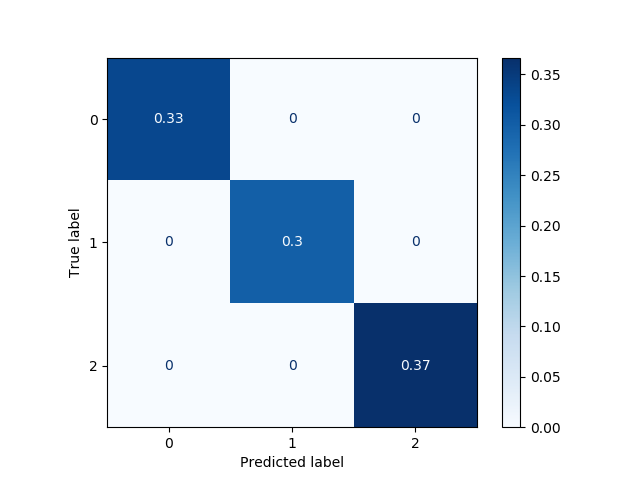

In [13]:
# Display HTML output artifacts
from IPython.display import display, HTML
display(HTML(filename=train_run.outputs['confusion-matrix']))


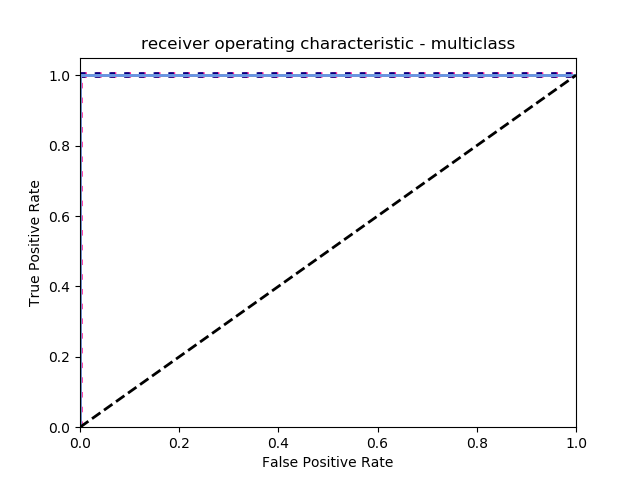

In [14]:
display(HTML(filename=train_run.outputs['roc-multiclass']))

<a id="gs-explore-data-w-pandas-df"></a>

### Exploring the Data with pandas DataFrames

Run the following code to use pandas DataFrames to read your data set, extract some basic statistics, and display them.

In [15]:
# Read your data set
df = mlrun.run.get_dataitem(train_run.outputs['test_set']).as_df()

In [16]:
# Display a portion of the read data
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),label
0,6.1,2.8,4.7,1.2,1
1,5.7,3.8,1.7,0.3,0
2,7.7,3.8,6.7,2.2,2
3,6.0,2.9,4.5,1.5,1
4,6.8,2.8,4.8,1.4,1


In [17]:
# Calculate and display the number of data-set items
print(f'Total number of rows: {len(df)}')

Total number of rows: 30


In [18]:
# Display statistics grouped by label
df.groupby(['label']).describe()

sepal length (cm)                                                  \
                  count      mean       std  min  25%   50%    75%  max   
label                                                                     
0                  10.0  5.070000  0.346570  4.7  4.8  4.95  5.325  5.7   
1                   9.0  6.011111  0.391933  5.6  5.7  6.00  6.200  6.8   
2                  11.0  6.690909  0.656437  5.8  6.3  6.50  6.950  7.9   

      sepal width (cm)            ... petal length (cm)      petal width (cm)  \
                 count      mean  ...               75%  max            count   
label                             ...                                           
0                 10.0  3.330000  ...               1.6  1.7             10.0   
1                  9.0  2.766667  ...               4.7  4.8              9.0   
2                 11.0  3.218182  ...               5.9  6.7             11.0   

                                                      
           mean       std  min   25%   50%  75%  max  
label                                                 
0      0.250000  0.108012  0.1  0.20  0.25  0.3  0.4  
1      1.344444  0.166667  1.1  1.20  1.30  1.5  1.6  
2      2.145455  0.269680  1.8  1.95  2.10  2.4  2.5  

[3 rows x 32 columns]

<a id="gs-tutorial-2-step-explore-data-w-mlrun-func"></a>

## Step 3: Exploring the Data with an MLRun Marketplace Function

You can perform further data exploration by leveraging **the MLRun functions marketplace** (a.k.a. "the MLRun functions hub").
This marketplace is a centralized location for open-source contributions of function components that are commonly used in machine-learning development.
The location of the marketplace is configured via the `hub_url` MLRun configuration.
By default, it points to the [mlrun/functions](https://github.com/mlrun/functions/) GitHub repository.
> The `hub_url` is pointing to the raw github URL, and can be defined with `{name}` and `{tag}` annotations, as seen in the default:  
`https://raw.githubusercontent.com/mlrun/functions/{tag}/{name}/function.yaml`


In this step you'll use the [`describe` marketplace function](https://github.com/mlrun/functions/tree/master/describe), which performs data exploration on a provided data set, to extract information from your data set, analyze it, and visualize relevant information in different ways.

### Adding an Exploration Function

Use `import_function`, which adds or updates a function object in a project, to load the `describe` marketplace function into a new `describe` project function. 
The tutorial code sets the first `import_function` parameter **`url`** which identities the function to load.

>  MLRun supports multiple types of URL formats.
  The example uses the `hub://...` format to point to the `describe` function-code directory in the MLRun functions marketplace (`'hub://describe'`).
  > Different tags could be specified by specifying: `hub://<function_name>:<tag>`

In [20]:
describe = mlrun.import_function('hub://describe').apply(mount_v3io())

### Viewing the Function Documentation

Use the `doc` method to view the embedded documentation of the `describe` function.

In [21]:
describe.doc()

function: describe
describe and visualizes dataset stats
default handler: summarize
entry points:
  summarize: Summarize a table
    context(MLClientCtx)  - the function context, default=
    table(DataItem)  - MLRun input pointing to pandas dataframe (csv/parquet file path), default=
    label_column(str)  - ground truth column label, default=None
    class_labels(List[str])  - label for each class in tables and plots, default=[]
    plot_hist(bool)  - (True) set this to False for large tables, default=True
    plots_dest(str)  - destination folder of summary plots (relative to artifact_path), default=plots
    update_dataset  - when the table is a registered dataset update the charts in-place, default=False


### Running the Exploration Function

Run the following code to execute the `describe` project function as a Kubernetes job by using the MLRun `run` method.
The returned run object is stored in a `describe_run` variable.

The location of the data set is the only input that you need to provide.
This information is provided as a `table` input artifact that points to the `iris_dataset` output artifact of the `get_data` job that you ran in the previous steps (using the job's `get_data_run` run object &mdash; see [Tutorial 1 Step 2](./01-mlrun-basics.ipynb#gs-tutorial-1-step-create-basic-function).

In [22]:
describe_run = describe.run(params={'label_column': 'label'},
                            inputs={"table":
                                    train_run.outputs['test_set']})

> 2021-01-24 19:10:47,096 [info] starting run describe-summarize uid=590a1562f6ba4acfb9ebe2b2c9b7da11 DB=http://mlrun-api:8080
> 2021-01-24 19:10:47,227 [info] Job is running in the background, pod: describe-summarize-bnsrz
> 2021-01-24 19:10:55,883 [info] run executed, status=completed
final state: completed


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
getting-started-tutorial-admin,...c9b7da11,0,Jan 24 19:10:51,completed,describe-summarize,v3io_user=adminkind=jobowner=adminhost=describe-summarize-bnsrz,table,label_column=label,,histogramsviolinimbalanceimbalance-weights-veccorrelation-matrixcorrelation


to track results use .show() or .logs() or in CLI: 
!mlrun get run 590a1562f6ba4acfb9ebe2b2c9b7da11 --project getting-started-tutorial-admin , !mlrun logs 590a1562f6ba4acfb9ebe2b2c9b7da11 --project getting-started-tutorial-admin
> 2021-01-24 19:10:56,379 [info] run executed, status=completed


### Reviewing the Run Output

The output cell for your code execution contains a run-information table.
You can also view run information in the MLRun dashboard; see the output-review information in Step 2, only this time look for the `describe-summarize` job and related artifacts.

The `describe` function generates three HTML output artifacts, which provide visual insights for your data set &mdash; `histograms`, `imbalance`, and `correlation`.
The artifacts are stored as HTML files in your project's artifacts directory, under **/User/getting-started-tutorial/jobs/plots/**.
The following code displays the artifact files in the notebook.


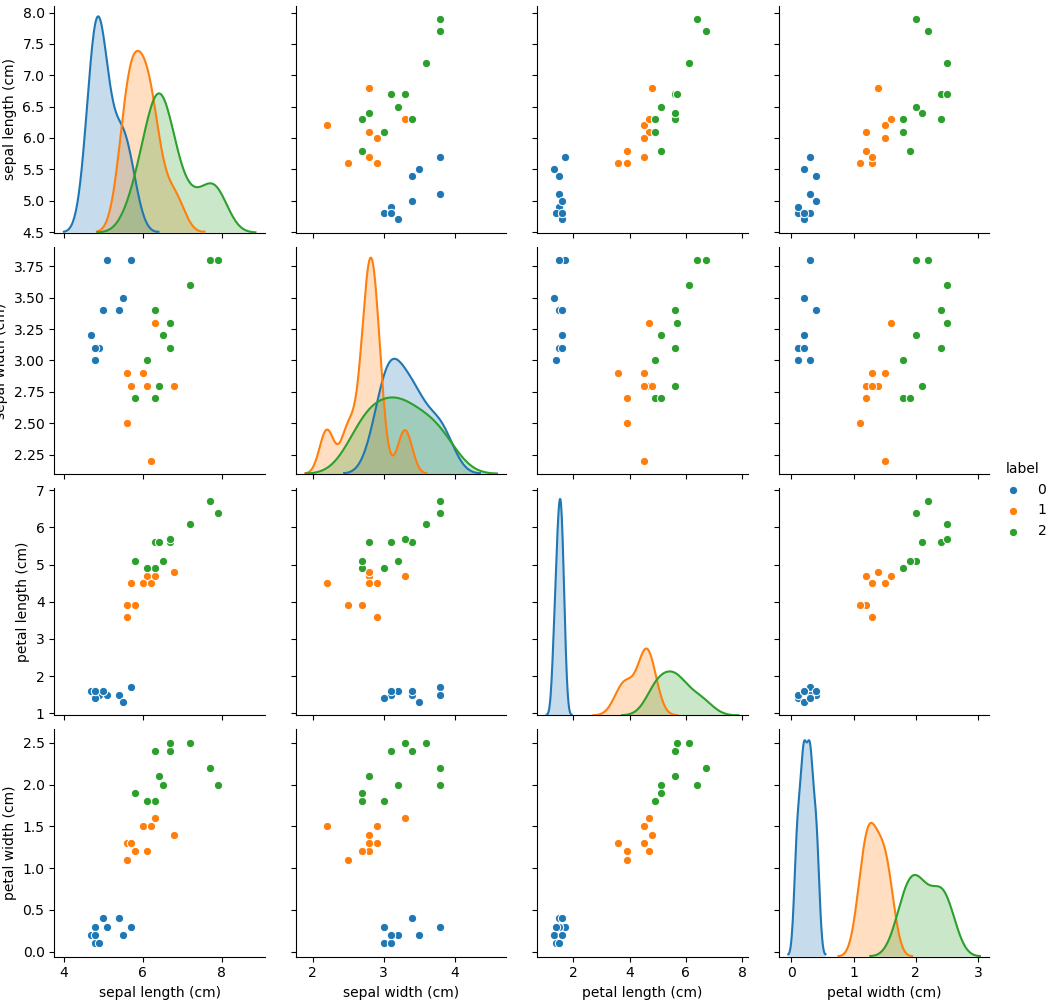

In [23]:
# Display the `histograms` artifact
display(HTML(describe_run.outputs['histograms']))


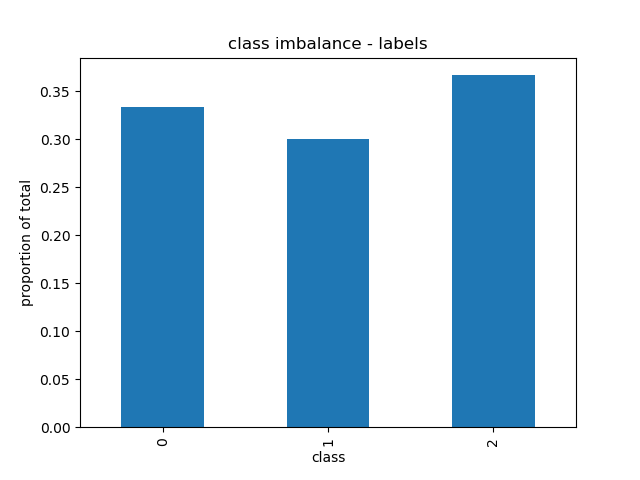

In [24]:
# Display the `imbalance` artifact
display(HTML(filename=describe_run.outputs['imbalance']))


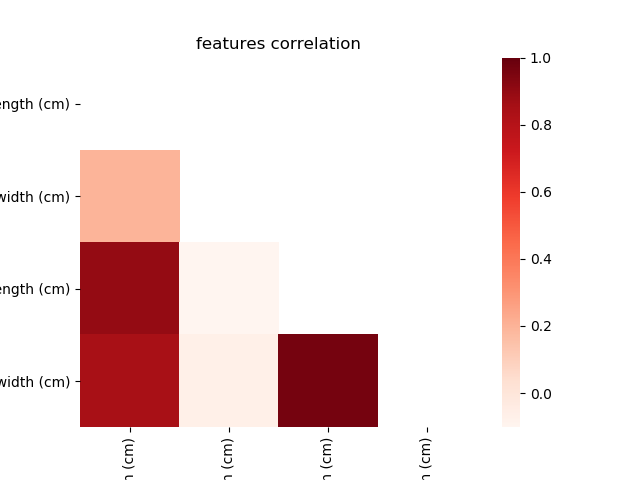

In [25]:
# Display the `correlation` artifact
display(HTML(filename=describe_run.outputs['correlation']))

<a id="gs-tutorial-2-step-test-model"></a>

## Step 4: Testing Your Model

Now that you have a trained model, you can test it: run a task that uses the [`test_classifier` marketplace function](https://github.com/mlrun/functions/tree/master/test_classifier) to run the selected trained model against the test data set, as returned for the training task (`train`) in the previous step.

### Adding a Test Function

Run the following code to add to your project a `test` function that uses the `test_classifier` marketplace function code, and create a related `test` function object.

In [26]:
test = mlrun.import_function('hub://test_classifier').apply(mount_v3io())

### Running a Model-Testing Task

Configure parameters for the test function (`params`), and provide the selected trained model from the `train` task as an input artifact (`inputs`).

In [27]:
test_run = test.run(name="test",
                    params={"label_column": "label",
                            "plots_dest": path.join("plots", "test")},
                    inputs={"models_path": train_run.outputs['model'],
                            "test_set": train_run.outputs['test_set']})

> 2021-01-24 19:10:56,574 [info] starting run test uid=cf858a3451714961a6da0443a739e501 DB=http://mlrun-api:8080
> 2021-01-24 19:10:56,713 [info] Job is running in the background, pod: test-twpp9
> 2021-01-24 19:11:01,881 [info] run executed, status=completed
final state: completed


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
getting-started-tutorial-admin,...a739e501,0,Jan 24 19:11:01,completed,test,v3io_user=adminkind=jobowner=adminhost=test-twpp9,models_pathtest_set,label_column=labelplots_dest=plots/test,accuracy=1.0test-error=0.0auc-micro=1.0auc-weighted=1.0f1-score=1.0precision_score=1.0recall_score=1.0,confusion-matrixprecision-recall-multiclassroc-multiclasstest_set_preds


to track results use .show() or .logs() or in CLI: 
!mlrun get run cf858a3451714961a6da0443a739e501 --project getting-started-tutorial-admin , !mlrun logs cf858a3451714961a6da0443a739e501 --project getting-started-tutorial-admin
> 2021-01-24 19:11:02,825 [info] run executed, status=completed


<a id="gs-test-model-run-output-review"></a>

### Reviewing the Run Output

Check the output information for your run in Jupyter Notebook and on the MLRun dashboard.

Use the following code to display information from the run object &mdash; the accuracy of the model, and the `confusion` and `roc` HTML output artifacts.

Test Accuracy: 1.0



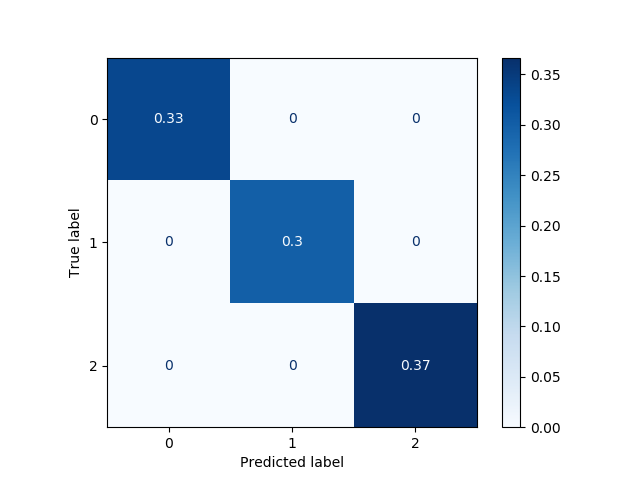


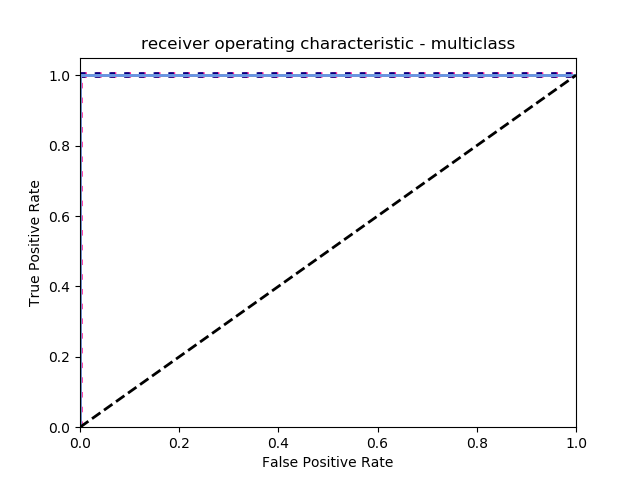

In [28]:
# Display the model accuracy
print(f'Test Accuracy: {test_run.outputs["accuracy"]}')

# Display HTML output artifacts
display(HTML(filename=test_run.outputs['confusion-matrix']))
display(HTML(filename=test_run.outputs['roc-multiclass']))

<a id="gs-done"></a>

## Done!

Congratulation! You've completed Part 2 of the MLRun getting-started tutorial.
Proceed to [Part 3](003-model-serving.ipynb) to learn how to deploy and server your model using a serverless function.